In [1]:
import sys
import os

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution
from utils import score
# from numba import njit

In [36]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [37]:
def greedy_2_regret_cycle(starting_point: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list:
    cost_matrix = (distance_matrix + costs).T
    n = len(distance_matrix)
    num_nodes_to_use = n // 2

    cycle = [starting_point]
    unvisited = list(range(n))
    unvisited.remove(starting_point)
    best_insertion = None
    min_increase = float('inf')
    nearest = min(unvisited, key=lambda i: cost_matrix[starting_point][i])
    cycle.append(nearest)
    unvisited.remove(nearest)
  
    for i in unvisited:
            increase = (
                    cost_matrix[cycle[0]][i] +
                    cost_matrix[i][cycle[1]] 
    
                )
            if increase < min_increase:
                    min_increase = increase
                    best_insertion = (i, 0)

    i, j = best_insertion
    cycle.insert(j+2, i)
    unvisited.remove(i)
    while len(cycle) < num_nodes_to_use:
        best_insertion = None
        max_regret = float('-inf')

        for i in unvisited:
            best_increase = float('inf')
            second_best_increase = float('inf')
            best_position = None
            
            for j in range(len(cycle)):
                k = (j + 1) % len(cycle)
                increase = (
                    cost_matrix[cycle[j]][i] + 
                    cost_matrix[i][cycle[k]] - 
                    cost_matrix[cycle[j]][cycle[k]]
                )
                if increase < best_increase:
                    second_best_increase = best_increase
                    best_increase = increase
                    best_position = k
                elif increase < second_best_increase:
                    second_best_increase = increase
            regret = second_best_increase - best_increase
            if regret > max_regret:
                max_regret = regret
                best_insertion = (i, best_position)
        i, best_position = best_insertion
        cycle.insert(best_position, i)
        unvisited.remove(i)

    return cycle

In [38]:
def greedy_2_regret_cycle2(starting_point: int, distance_matrix: np.ndarray, costs: np.ndarray) -> list:
    cost_matrix = (distance_matrix + costs).T 
    n = len(distance_matrix)
    num_nodes_to_use = n // 2


    cycle = np.array([starting_point])  
    unvisited = np.ones(n, dtype=bool) 
    unvisited[starting_point] = False

 
    unvisited_indices = np.where(unvisited)[0]  
    nearest = unvisited_indices[np.argmin(cost_matrix[starting_point, unvisited_indices])] 
    cycle = np.append(cycle, nearest) 
    unvisited[nearest] = False  
    unvisited_indices = np.where(unvisited)[0]
    increases = (
        cost_matrix[cycle[0], unvisited_indices[:, None]] +  
        cost_matrix[unvisited_indices[:, None], cycle[1]]    
    )
    min_idx = np.argmin(increases)
    best_insertion = (unvisited_indices[min_idx], 0)  
    i, j = best_insertion
    cycle = np.insert(cycle, j + 2, i)  
    unvisited[i] = False  
    while len(cycle) < num_nodes_to_use:
        cycle_len = len(cycle)
        unvisited_indices = np.where(unvisited)[0]
        j_indices = np.arange(cycle_len)
        k_indices = (j_indices + 1) % cycle_len  
        cost_increases = (
            cost_matrix[cycle[j_indices], unvisited_indices[:, None]] +  
            cost_matrix[unvisited_indices[:, None], cycle[k_indices]] - 
            cost_matrix[cycle[j_indices], cycle[k_indices]]
        )
        best_increases = np.min(cost_increases, axis=1)  
        second_best_increases = np.partition(cost_increases, 1, axis=1)[:, 1] 
        regrets = second_best_increases - best_increases
        max_regret_idx = np.argmax(regrets)
        i = unvisited_indices[max_regret_idx]
        best_position = np.argmin(cost_increases[max_regret_idx])
        cycle = np.insert(cycle, (best_position + 1) % cycle_len, i) 
        unvisited[i] = False  
    return cycle.tolist()

In [39]:
def greedy_2_regret_weighted(starting_point: int, distance_matrix: np.ndarray, costs: np.ndarray, weight_regret=0.5) -> list:
    cost_matrix = (distance_matrix + costs).T 
    n = len(distance_matrix)
    num_nodes_to_use = n // 2


    cycle = np.array([starting_point])  
    unvisited = np.ones(n, dtype=bool) 
    unvisited[starting_point] = False

 
    unvisited_indices = np.where(unvisited)[0]  
    nearest = unvisited_indices[np.argmin(cost_matrix[starting_point, unvisited_indices])] 
    cycle = np.append(cycle, nearest) 
    unvisited[nearest] = False  
    unvisited_indices = np.where(unvisited)[0]
    increases = (
        cost_matrix[cycle[0], unvisited_indices[:, None]] +  
        cost_matrix[unvisited_indices[:, None], cycle[1]]    
    )
    min_idx = np.argmin(increases)
    best_insertion = (unvisited_indices[min_idx], 0)  
    i, j = best_insertion
    cycle = np.insert(cycle, j + 2, i)  
    unvisited[i] = False  
    while len(cycle) < num_nodes_to_use:
        cycle_len = len(cycle)
        unvisited_indices = np.where(unvisited)[0]
        j_indices = np.arange(cycle_len)
        k_indices = (j_indices + 1) % cycle_len  
        cost_increases = (
            cost_matrix[cycle[j_indices], unvisited_indices[:, None]] +  
            cost_matrix[unvisited_indices[:, None], cycle[k_indices]] - 
            cost_matrix[cycle[j_indices], cycle[k_indices]]
        )
        best_increases = np.min(cost_increases, axis=1)  
        second_best_increases = np.partition(cost_increases, 1, axis=1)[:, 1] 
        
        weighted= best_increases - weight_regret*second_best_increases

        max_weighted_idx = np.argmin(weighted)
        i = unvisited_indices[max_weighted_idx]
        best_position = np.argmin(cost_increases[max_weighted_idx])
        cycle = np.insert(cycle, (best_position + 1) % cycle_len, i) 
        unvisited[i] = False  
    return cycle.tolist()

scores of nn:  105852 115630.16 123171
[159, 195, 146, 22, 20, 18, 108, 67, 36, 140, 93, 117, 170, 153, 183, 89, 23, 83, 64, 15, 9, 37, 128, 172, 57, 55, 3, 32, 49, 102, 144, 132, 21, 7, 164, 71, 27, 39, 165, 8, 185, 174, 81, 98, 17, 157, 188, 56, 171, 16, 78, 25, 44, 120, 2, 75, 86, 97, 189, 94, 130, 137, 66, 176, 80, 151, 133, 79, 63, 136, 53, 180, 154, 6, 135, 194, 161, 123, 29, 126, 112, 4, 190, 177, 147, 48, 34, 160, 184, 28, 43, 65, 197, 59, 118, 60, 46, 198, 139, 193]


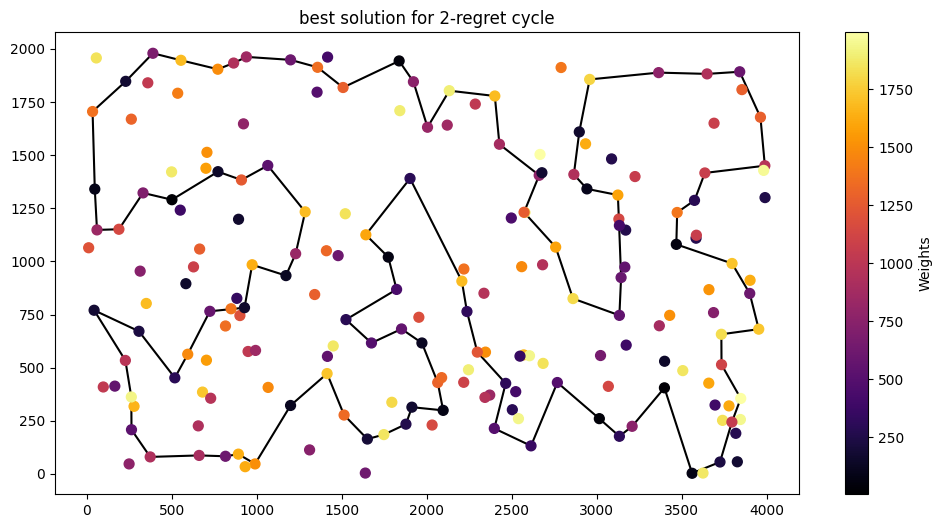

In [75]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_cycle2(x, dist, costs)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, dist, costs))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, 'best solution for 2-regret cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_1.csv', header=False, index=False)

scores of nn:  71108 72130.045 73395
[117, 0, 46, 68, 139, 193, 41, 115, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 196, 81, 90, 40, 165, 185, 106, 178, 138, 14, 144, 62, 9, 148, 102, 49, 52, 55, 92, 57, 129, 82, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143]


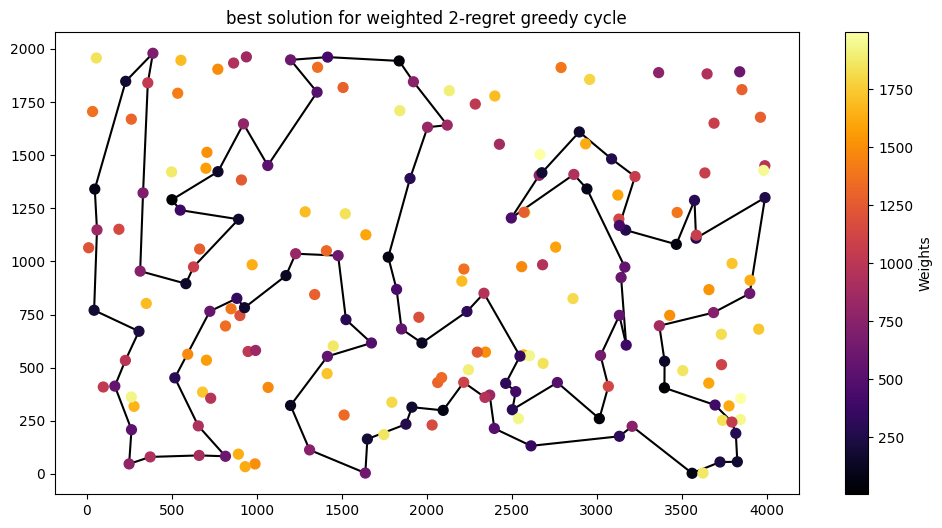

In [76]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_weighted(x, dist, costs, weight_regret=0.5)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, dist, costs))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinates, costs, 'best solution for weighted 2-regret greedy cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_2.csv', header=False, index=False)

scores of nn:  67568 72656.19 77329
[60, 20, 59, 28, 4, 140, 183, 174, 181, 83, 55, 34, 170, 53, 184, 155, 84, 70, 132, 169, 188, 6, 150, 147, 134, 43, 139, 11, 33, 160, 39, 35, 143, 106, 119, 81, 41, 111, 68, 8, 104, 157, 171, 177, 123, 25, 118, 116, 121, 125, 191, 115, 10, 133, 17, 107, 100, 63, 96, 135, 38, 16, 197, 24, 198, 117, 164, 105, 80, 162, 45, 5, 7, 36, 79, 91, 141, 97, 146, 153, 186, 163, 165, 127, 26, 114, 137, 75, 93, 48, 166, 194, 176, 64, 86, 185, 52, 57, 66, 148]


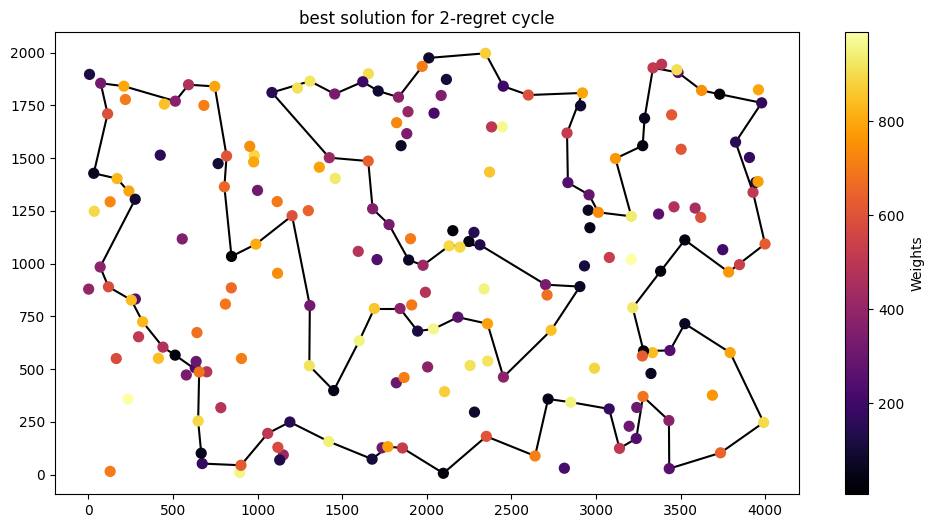

In [78]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_cycle2(x, distb, costsb)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, distb, costsb))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinatesb, costsb, 'best solution for 2-regret cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_3.csv', header=False, index=False)

scores of nn:  47144 50899.49 55700
[199, 148, 47, 66, 94, 60, 20, 28, 149, 4, 152, 170, 34, 55, 18, 62, 128, 124, 106, 143, 35, 109, 0, 29, 160, 33, 11, 134, 74, 118, 121, 51, 90, 131, 54, 31, 193, 117, 1, 38, 135, 63, 122, 133, 10, 115, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 139, 182, 138, 104, 8, 111, 82, 21, 177, 5, 45, 142, 78, 175, 36, 61, 91, 141, 77, 81, 153, 187, 163, 89, 127, 137, 114, 103, 26, 176, 113, 194, 166, 86, 185, 179, 22, 99, 130, 95, 140, 183]


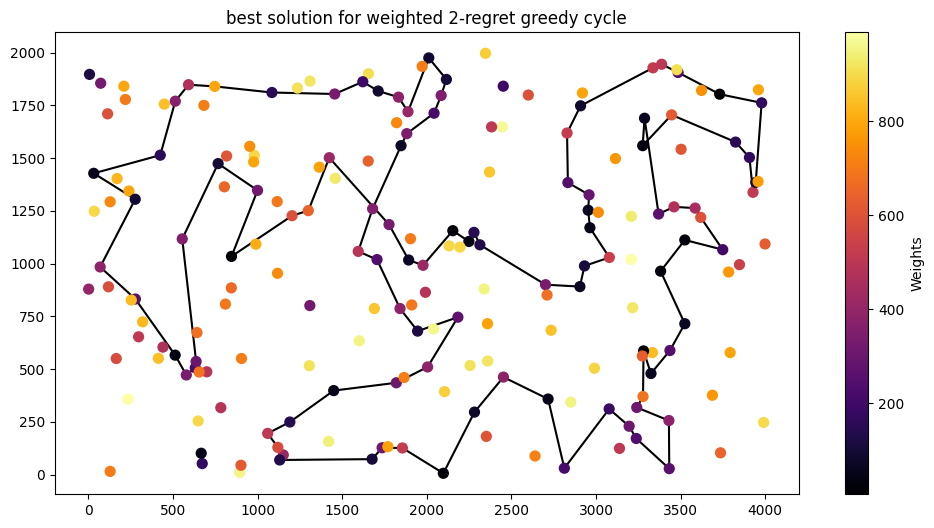

In [77]:
scores_2=[]
sols_2=[]

for x in range(200):
   
    solution_2=greedy_2_regret_weighted(x, distb, costsb)
    sols_2.append(solution_2)

    scores_2.append(score(solution_2, distb, costsb))   

print('scores of nn: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
print(sols_2[scores_2.index(min(scores_2))])
plot_solution(sols_2[scores_2.index(min(scores_2))], coordinatesb, costsb, 'best solution for weighted 2-regret greedy cycle')
sol_1=np.array(sols_2[scores_2.index(min(scores_2))])
pd.DataFrame(sol_1).to_csv('sol_4.csv', header=False, index=False)

In [81]:
%%timeit
greedy_2_regret_cycle2(0, dist, costs)

12.3 ms ± 70.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
%%timeit
greedy_2_regret_weighted(0, dist, costs)

12.7 ms ± 193 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
